In [41]:
import os
from PIL import Image
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Set up the data directory
data_dir = 'Register Numbers/'

# Load image paths and their corresponding labels from filenames
image_pairs = [
    (os.path.join(data_dir, f), f.split('.')[0]) 
    for f in os.listdir(data_dir) 
    if f.endswith('.png')
]

# Validate that each label is a 12-digit register number
def validate_label(label):
    if len(label) != 12 or not label.isdigit():
        raise ValueError(f"Invalid register number: {label}")
    return label

# Clean the data by ensuring valid labels
cleaned_pairs = [(path, validate_label(label[:12])) for path, label in image_pairs]

# Split the data into train (80%), validation (10%), and test (10%)
random.shuffle(cleaned_pairs)
total = len(cleaned_pairs)
train = cleaned_pairs[:int(0.8 * total)]
val = cleaned_pairs[int(0.8 * total):int(0.9 * total)]
test = cleaned_pairs[int(0.9 * total):]
print(f"Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")

Train: 4276, Val: 535, Test: 535


In [42]:
class RegisterNumberDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        # Encode label: '0'->1, '1'->2, ..., '9'->10 (0 reserved for blank in CTC)
        label_seq = [int(digit) + 1 for digit in label]
        return image, torch.tensor(label_seq, dtype=torch.long)

# Define image preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((32, 256)),          # Resize to a fixed height and width
    transforms.ToTensor(),                 # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))   # Normalize to [-1, 1]
])

# Create datasets for train, validation, and test
train_dataset = RegisterNumberDataset([p for p, _ in train], [l for _, l in train], transform=transform)
val_dataset = RegisterNumberDataset([p for p, _ in val], [l for _, l in val], transform=transform)
test_dataset = RegisterNumberDataset([p for p, _ in test], [l for _, l in test], transform=transform)

# Set up data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [43]:
class CRNN(nn.Module):
    def __init__(self, num_classes=11):
        super(CRNN, self).__init__()
        # CNN for feature extraction
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x256 -> 16x128
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x128 -> 8x64
        )
        # RNN input size: 64 channels * 8 height = 512
        self.rnn_input_size = 64 * 8
        self.rnn = nn.LSTM(self.rnn_input_size, 128, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(128 * 2, num_classes)  # Bidirectional: 128*2

    def forward(self, x):
        # Input: (batch, 1, 32, 256)
        x = self.cnn(x)  # Output: (batch, 64, 8, 64)
        batch, channels, height, width = x.size()
        x = x.permute(0, 3, 1, 2).reshape(batch, width, channels * height)  # (batch, 64, 512)
        x, _ = self.rnn(x)  # (batch, 64, 256)
        x = self.fc(x)  # (batch, 64, 11)
        return x

# Initialize the model and move it to GPU if available
model = CRNN(num_classes=11)  # 11 classes: 0 (blank) + digits 0-9
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CRNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): LSTM(512, 128, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=256, out_features=11, bias=True)
)

In [44]:
# Define loss function and optimizer
criterion = nn.CTCLoss(blank=0)  # Blank label is 0 for CTC
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, targets in train_loader:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(images)  # (batch, T, num_classes)
        outputs = outputs.log_softmax(2).permute(1, 0, 2)  # (T, batch, num_classes)
        batch_size = images.size(0)
        input_lengths = torch.full((batch_size,), outputs.size(0), dtype=torch.long, device=device)
        target_lengths = torch.full((batch_size,), 12, dtype=torch.long, device=device)
        targets = targets.view(-1)  # Flatten: batch_size * 12
        loss = criterion(outputs, targets, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/200, Loss: 1.8935
Epoch 2/200, Loss: 1.2258
Epoch 3/200, Loss: 1.0843
Epoch 4/200, Loss: 1.0296
Epoch 5/200, Loss: 0.9916
Epoch 6/200, Loss: 0.9174
Epoch 7/200, Loss: 0.7892
Epoch 8/200, Loss: 0.6104
Epoch 9/200, Loss: 0.4398
Epoch 10/200, Loss: 0.2803
Epoch 11/200, Loss: 0.1894
Epoch 12/200, Loss: 0.1334
Epoch 13/200, Loss: 0.1032
Epoch 14/200, Loss: 0.0863
Epoch 15/200, Loss: 0.0758
Epoch 16/200, Loss: 0.0634
Epoch 17/200, Loss: 0.0557
Epoch 18/200, Loss: 0.0474
Epoch 19/200, Loss: 0.0414
Epoch 20/200, Loss: 0.0387
Epoch 21/200, Loss: 0.0364
Epoch 22/200, Loss: 0.0288
Epoch 23/200, Loss: 0.0291
Epoch 24/200, Loss: 0.0245
Epoch 25/200, Loss: 0.0278
Epoch 26/200, Loss: 0.0250
Epoch 27/200, Loss: 0.0188
Epoch 28/200, Loss: 0.0176
Epoch 29/200, Loss: 0.0351
Epoch 30/200, Loss: 0.0147
Epoch 31/200, Loss: 0.0110
Epoch 32/200, Loss: 0.0100
Epoch 33/200, Loss: 0.0081
Epoch 34/200, Loss: 0.0081
Epoch 35/200, Loss: 0.0068
Epoch 36/200, Loss: 0.0083
Epoch 37/200, Loss: 0.0057
Epoch 38/2

In [39]:
#Epoch 19/20, Loss: 0.1123
#Epoch 20/20, Loss: 0.0973 for 50 epochs and 0.001 lr


# 81.12 accuracy for 70 epochs

# Test Accuracy: 85.61% for 100 epochs

In [40]:
def decode_predictions(outputs):
    outputs = outputs.softmax(2).argmax(2)  # (batch, T)
    batch_size = outputs.size(0)
    decoded = []
    for b in range(batch_size):
        seq = outputs[b].cpu().numpy()
        prev = -1
        result = []
        for s in seq:
            if s != 0 and s != prev:  # Skip blanks and repeats
                result.append(s - 1)  # Map back: 1->0, 2->1, ..., 10->9
            prev = s
        decoded.append(''.join(map(str, result)))
    return decoded

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        outputs = model(images)  # (batch, T, num_classes)
        predictions = decode_predictions(outputs)
        target_labels = [''.join(str(d - 1) for d in t.tolist()) for t in targets]
        for pred, target in zip(predictions, target_labels):
            if pred == target:
                correct += 1
            total += 1
print(f"Test Accuracy: {correct/total*100:.2f}%")

Test Accuracy: 85.61%


In [ ]:
## for 70 epochs and 0.001 learning rate

#Test Accuracy: 81.12%


Predicted Register Number: 2222060288


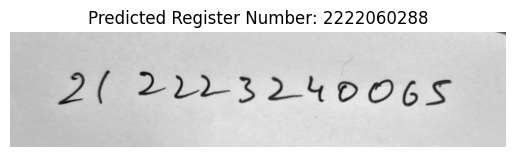

In [33]:
#%% Cell 6: Prediction Function
import torch
from PIL import Image
from torchvision import transforms

def predict_register_number(model, image_path, device, transform):
    image = Image.open(image_path).convert('L')
    image = transform(image)
    image = image.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        image = image.to(device)
        output = model(image)
    output = output.softmax(2).argmax(2)
    seq = output[0].cpu().numpy()
    prev = -1
    result = []
    for s in seq:
        if s != 0 and s != prev:
            result.append(s - 1)
        prev = s
    predicted_number = ''.join(map(str, result))
    return predicted_number

# Reuse the transform from training
transform = transforms.Compose([
    transforms.Resize((32, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

#%% Cell 7: Test Prediction
image_path = 'my_reg.png'  # Replace with your image path
predicted_number = predict_register_number(model, image_path, device, transform)
print(f"Predicted Register Number: {predicted_number}")

#%% Cell 8: Visualize (Optional)
import matplotlib.pyplot as plt
image = Image.open(image_path).convert('L')
plt.imshow(image, cmap='gray')
plt.title(f"Predicted Register Number: {predicted_number}")
plt.axis('off')
plt.show()

In [ ]:
# prediction for 50 epochs and 0.001 learning rate
#my reg num predicted as :
#Predicted Register Number: 212222220084
